In [5]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Simulating the a path from Brownian Motion

In [6]:
# we draw a step from [-1/2, 0, 1/2]
def draw_step():
    return (np.random.randint(3) - 1)/2, 1/3

def simulate_random_walk(dt, T, start=0):
    """
    Simulates a 1D random walk
    """
    Ws = [start] # store all positions of W
    ts = [0]
    for t in np.arange(0, T, dt):
        # draw a step
        step, _  = draw_step()
        # add step to previous
        Wt = Ws[-1] + step
        # append to the store
        Ws.append(Wt)
        ts.append(t)
        
    return Ws, ts

 Let us visualize to see how it looks:

In [7]:
Ws, ts = simulate_random_walk(0.5, 100, start=0.4)

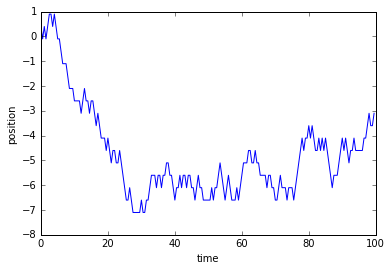

In [8]:
plt.plot(ts, Ws)
plt.ylabel('position')
plt.xlabel('time')

# Scenario

Assume that we know the particle starts around $0\pm c$, given a realization of the above process, can we find the posterior distribution of start points? i.e we want $P(W_0 | W_T)$. 

From the above we have that the transition probabilities are defined as: $P(W_{t+1} | W_t) = \frac{1}{3}$ for all outcomes of $W_{t+1}$. We can, therefore, write that 
$$P(W_0 | W_T) = \frac{P(W_T | W_0) P(W_0)}{P(W_T)}$$


We want to find $\mathbb{E}[W_0 | W_T] = \sum_{w_0} w_0 p(w_0 | w_t) dw_0 $. The Monte Carlo estimate is given by:

$$\mathbb{E}[W_0 | W_T] \approx \frac{1}{n}\sum_n w_0^{(n)}$$ where $w_0^{(n)}\sim p(w_o | w_T)$

The question now becomes: how do we sample from this posterior distribution $p(w_0 | w_T)$? From above, we have found that this posterior can be broken down. So what if we sample $w_0\sim p(w_0)$ and then plug it into $p(w_T | w_0)$?

Note that $p(w_T|w_0)=\sum_{w_{t-1}} p(w_T | w_{T-1}, w_0) p(w_{T-1} | w_0)=\ldots$

Basically what this does is sum over all possible paths from $w_0$ to $w_T$. So perhaps, we could just draw $w_0 \sim p(w_0)$ and then run the forward process to get $w_T$. Note that this can be computationally intensive because many of the paths will not lead to $w_T$:

In [9]:
# Approximate Bayesian Computation?
mc_samples = 5000
c = 2
W_T_true = Ws[-1] # the last position
w0s = []
trajectories = []
for i in range(mc_samples):
    w0 = np.random.uniform(-c, c)
    wT, _ = simulate_random_walk(0.5, 100, start=w0)
    
    #  here we accept that this path is close enough
    # if it is at most one step away from the observed.
    if np.abs(W_T_true - wT[-1]) < 0.5:
        w0s.append(w0)
        trajectories.append(wT)

w0_estimated = np.mean(w0s)
var_w0 = np.var(w0s)
print('Estimated w0:', w0_estimated, '|variance:',var_w0)

Estimated w0: -0.0467024819906 |variance: 1.31866827487


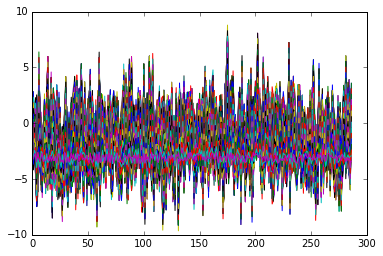

In [11]:
ax = plt.plot(trajectories)

In [12]:
# the reverse draw is the same as the forward draw.
def reverse_step():
    step, prob = draw_step()
    return -step, prob

# MC sampling
Consider that we have $\mathbb{E}[W_0 | W_T] \approx \frac{1}{n}\sum_n w_0^{(n)}$ where $w_0^{(n)}\sim p(w_o | w_T)$ what if we worked in reverse to sample from $p(w_0 | w_T)$ by leveraging the one step transition probabilities?

In [13]:
from scipy.stats import uniform

In [20]:
# MC approximation
mc_samples = 500
c = 2
trajectories = []
W_T_true = Ws[-1] # the position we observed.
T = len(Ws)
successful_trees = 0
w0s = []
endpoints = []
for i in range(mc_samples):
    w_t = Ws[-1] # start at the end
    traj = [w_t]
    log_path_prob = 0
    
    # go in reverse time:
    for t in reversed(range(0, T)):
        
        # draw a reverse step
        # this is p(w_{t} | w_{t+1})
        step, prob = reverse_step()

        # probability of the path gets updated:
        log_path_prob += np.log(prob)
        # take the reverse step:
        w_t = w_t + step
        traj.append(w_t)

    log_path_prob += np.log(uniform.pdf(w_t, -c, c+c))
    trajectories.append(traj)
    if log_path_prob > -10**10:
        successful_trees += 1
        w0s.append(w_t)
        endpoints.append(w_t)

successful_trees /= mc_samples

print('Estimated w0:', np.mean(w0s), '| variance:',np.var(w0s))
print(successful_trees)

Estimated w0: 0.0875 | variance: 1.39609375
0.24


/home/ml/zahmed8/.local/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


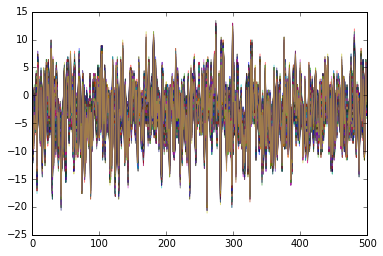

In [21]:
_ = plt.plot(trajectories, alpha=0.5)

# Importance Sampling
75% of our reverse runs were unsucessful! What if we could be more efficient with our draws? Consider:

$$\mathbb{E}_{w_0\sim p}[w_0 | w_F] = \int w_0~p(\tau~\text{starts at}~w_0| w_F)~d\tau$$

is the integral we want to estimate where $\tau$ is a tree. Consider the reformulation:

$$\int d\tau w_0 \frac{p(\tau~\text{starts at}~w_0| w_F)}{q(\tau~\text{starts at}~w_0| w_F)}q(\tau~\text{starts at}~w_0| w_F) = \mathbb{E}_{w_0\sim q}\bigg[w_0 \frac{p(\tau~\text{starts at}~w_0| w_F)}{q(\tau~\text{starts at}~w_0| w_F)} \bigg| w_F\bigg]$$

This basically says that if we draw from a different distribution $q$, we could "correct" the probability of obtaining that result from the original distribtion $p$ so that we can get the same integral. Therefore we now have that

$$\mathbb{E}_{w_0\sim q}\bigg[w_0 \frac{p(\tau~\text{starts at}~w_0| w_F)}{q(\tau~\text{starts at}~w_0| w_F)} \bigg| w_F\bigg]\approx \frac{1}{N}\sum_{n=1}^N w_0\frac{p(\tau~\text{starts at}~w_0 | w_F)}{q(\tau~\text{starts at}~w_0| w_F)}$$

In [128]:
def p_prob_transition(step):
    if step == 0.5:
        return 1/3
    elif step == -0.5:
        return 1/3
    elif step == 0:
        return 1/3
    else:
        raise ValueError('Unknown step size!')

In [149]:
# importance sampling

def draw_from_proposal(w, time_left, push_toward=0):
#     print('pos:',w)
#     print('toward:',push_toward)
    probs = np.array([np.exp(push_toward-w), np.exp(w-push_toward), np.exp(0.5)])
    probs /= np.sum(probs)
    choices = [1/2, -1/2, 0]
    choice = np.random.choice(choices, p=probs)
    prob = probs[choices.index(choice)]
    return choice, prob
    

mc_samples = 500
c = 2
W_T_true = Ws[-1] # the position we observed.
T = len(Ws)
successful_trees = 0
w0s = []
for i in range(mc_samples):
    w_t = Ws[-1] # start at the end
    path_prob = 1 # use 1 because we can multiply easily
    q_prob = 1
    # go in reverse time:
    for t in reversed(range(0, T)):
        
        # draw a reverse step from the proposal
        step, prob = draw_from_proposal(w_t, t, push_toward=0)
        q_prob *= prob
        # this is p(w_{t} | w_{t+1})
        path_prob *= p_prob_transition(step)
        
        # take the reverse step:
        w_t = w_t + step

    path_prob *= uniform.pdf(w_t, -c, c+c)

    if path_prob > 0:
        successful_trees += 1
        w0s.append(w_t * (path_prob / q_prob))

successful_trees /= mc_samples

print('Estimated w0:', np.mean(w0s), '| variance:',np.var(w0s))
print(successful_trees)

Estimated w0: -5.88403921507e-08 | variance: 1.52063793738e-12
1.0
